# Hausaufgabe
translate(Hausaufgabe) -> **Homework**

Halo!
На семинаре мы создали простую seq2seq модель на основе rnn для перевода, а сейчас постараемся засунуть туда attention. Работать будем с тем же датасетом DE->EN (датасеты получше просто не влезают в память колаба, но если у вас есть CPU+тонна времени или GPU побольше, то можно попробовать построить перевод на WMT14 или IWSLT )

В конце домашней работы предполагается написание отчета о проделанной работе.

In [0]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import numpy as np

import spacy

import random
import math
import time

from torchtext.datasets import TranslationDataset, Multi30k #WMT14, IWSLT
from torchtext.data import Field, BucketIterator

import torch.nn.functional as F

In [0]:
seed = 43

random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
! python -m spacy download en
! python -m spacy download de


spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
     |████████████████████████████████| 14.9MB 691kB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp36-none-any.whl size=14907056 sha256=eebb755cc5206b2ea6139e7ad8a34927d7cb520b8f76641d670ef30019178304
  Stored in directory: /tmp/pip-ephem-wheel-cache-xrxw2xpw/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


In [0]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings (tokens) and reverses it
    """
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

# немецкий язык является полем SRC, а английский в поле TRG
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

In [5]:
# В датасете содержится ~ 30к предложений средняя длина которых 11
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'),  fields = (SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:04<00:00, 299kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 92.1kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 86.8kB/s]


Давайте посмотрим что у нас с датасетом и сделаем словари для SRC и TGT

In [6]:
labels = ['train', 'validation', 'test']
dataloaders = [train_data, valid_data, test_data]
for d, l in zip(dataloaders, labels):
    print("Number of sentences in {} : {}".format(l, len(d.examples)))


Number of sentences in train : 29000
Number of sentences in validation : 1014
Number of sentences in test : 1000


In [7]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)
print("Number of words in source vocabulary", len(SRC.vocab))
print("Number of words in source vocabulary", len(TRG.vocab))

Number of words in source vocabulary 7855
Number of words in source vocabulary 5893


## Encoder

Энкодер будет ровно как в семинаре, с кдинственным изменением -- forward будет возвращать не только hidden, cell, но еще и outputs. Это нужно (надеюсь, вы уже поняли) для использования attention в декодере

In [0]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        """
        :param: input_dim is the size/dimensionality of the one-hot vectors that will be input to the encoder. This is equal to the input (source) vocabulary size.
        :param: emb_dim is the dimensionality of the embedding layer. This layer converts the one-hot vectors into dense vectors with emb_dim dimensions.
        :param: hid_dim is the dimensionality of the hidden and cell states.
        :param: n_layers is the number of layers in the RNN.
        :param: percentage of the dropout to use
        
        """
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_dim, emb_dim)
 
        self.rnn = nn.LSTM(input_size=emb_dim, num_layers = n_layers, hidden_size=hid_dim) #попробовать поменять на lstm или gru
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        """
        :param: src sentences (src_len x batch_size)
        """
        # embedded = <TODO> (src_len x batch_size x embd_dim)
        embedded = self.embedding(src)
        # dropout over embedding
        embedded = self.dropout(embedded)
        outputs, (hidden, cell) = self.rnn(embedded)
        # [Attention return is for lstm, but you can also use gru]
        return outputs, hidden, cell

## Decoder
Оп ля, а тут уже что-то новенькое

Мы будем реализовывать attention, который будет смотреть из tgt в src (НЕ self-attention). 

Определим два класса -- Attention и DecoderAttn. Мы разбили их на два класса, чтобы можно было играться с типом внимания, не меняя код DecoderAttn. Как вы помните с лекции, в качестве аттеншена можно брать любую странную функцию (конкатенация, маленькая сеточка, ...), и все будет работать! Поэтому вам предлагается попробовать несколько разных.


---------------------
Есть два подхода к реализации аттеншена:

Подход #1:

1. Вычисляется embed
2. На основе hidden c прошлого шага, embedded и (возможно) enc_out вычисляется attention, а точнее, веса attention (поэтому не забудьте softmax!!). Размерность batch_size * max_len, max_len -- максимальная длина предложения в батче, т.е. shape[0] от выхода энкодера.
3. К enc_out применяется attention: чаще всего dot product от enc_out и attention_weights (не забудьте про измерение батч. Чтобы нормально вычислить dot_product по батчу, вам поможет torch.bmm)
4. Берутся attention и embedded и сворачиваются в один вектор размерности такой, чтобы кормить его self.lstm. Например, это можно сделать с помощью обычного линейного слоя
5. Вычисляется новое скрытое состояние new_hidden. Это наша self.lstm, примененная к выходу пункта 4.
6. Вычисляется prediction, как в семинаре

Грубо говоря, вся разница с семинаром в том, что мы вместо того, чтобы embedded пихать в self.lstm, миксуем аттэншен на основе всего, что имеем (enc_out, hidden, embedded) и запихиваем в self.lstm микс аттэншена и embedded.

![alt text](https://i.imgur.com/cmkRY0r.png)


Подход #2:

1. Вычисляется embed
2. Вычисляется output, new_hidden (строчка output, (hidden, cell) = self.rnn(embedded, (hidden, cell)))
3. На основе output и enc_out вычисляется attention, а точнее, веса attention (поэтому не забудьте softmax!!)
3. К enc_out применяется attention: чаще всего dot product от enc_out и attention_weights (не забудьте про измерение батч. Чтобы нормально вычислить dot_product по батчу, вам поможет torch.bmm)
4. Вычисляется prediction на основе attention и output. Можно, например, взять nn.Linear() от конкатенации attention и output.

Разница с первым подходом в том, что мы сначала вычисляем выход rnn слоя, а потом смотрим вниманием на src и на основе выхода rnn и attn считаем выход (prediction). 

![alt text](https://i.imgur.com/5aWjQWv.png)


Вам предлагается реализовать хотя бы 1 из вариантов и хотя бы 2 варианта функции attention (в классе Attention)


In [0]:
class Attention(nn.Module):
    def __init__(self, batch_size, n_layers,hid_dim, method="one-layer-net", bidirectional = False): # add parameters needed for your type of attention
        super(Attention, self).__init__()
        self.method = method # attention method you'll use. e.g. "cat", "one-layer-net", "dot", ...
        self.batch_size = batch_size
        self.linear = nn.Linear(hid_dim*(bidirectional+1), 1)
        self.bidirectional = bidirectional
    #сначала разберем для одного слоя и bidirectional = False
        
    def forward(self, last_hidden, encoder_outputs, seq_len=None):
        last_hidden = last_hidden[-(1+self.bidirectional):]
        if self.bidirectional:
          last_hidden = torch.cat((last_hidden[0],last_hidden[1]), dim = -1).unsqueeze_(0)

        if self.method == 'one-layer-net':
          input = torch.cat((encoder_outputs, last_hidden), dim = 0)
          return F.softmax(self.linear(input)[:-1], dim = 1)

        elif self.method == 'dot':
          input = torch.sum(last_hidden*encoder_outputs, dim = -1).unsqueeze_(-1)
          return F.softmax(input, dim = 1)

        else:
          raise NameError('method does not exist')
        
class DecoderAttn(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, attention, dropout=0.1):
        super(DecoderAttn, self).__init__()
        
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        
        self.attn = attention # instance of Attention class

        # define layers
        self.embedding = nn.Embedding(output_dim,emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers) #(lstm embd, hid, layers, dropout), попробовать gru
        self.out = nn.Linear(self.hid_dim, self.output_dim) # Projection :hid_dim x output_dim
        self.dropout = nn.Dropout(dropout)

        # more layers you'll need for attention
        
    def forward(self, input, hidden, cell, encoder_output):
        # make decoder with attention
        # use code from seminar notebook as base and add attention to it
        input_ = input.unsqueeze(0)
        
        # (1 x batch_size x emb_dim)
        embedded = self.embedding(input_)# embd over input and dropout 
        embedded = self.dropout(embedded)

        attn_weights = self.attn.forward(hidden, encoder_output)
        new_hidden = torch.sum(encoder_output*attn_weights, dim = 0).unsqueeze(0) # (num_layers * num_directions, batch, hidden_size)
        #assert hidden.shape == new_hidden.shape
        output, (hidden, cell) = self.rnn(embedded, (new_hidden, cell))
        prediction = self.out(output.squeeze(0))
        return prediction, hidden, cell

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Seq2Seq module

Здесь опять ничего не поменяется кроме того, что энкодер теперь возвращает свой output, а декодер его принимает

In [0]:
# we need that to put it first to the decoder in 'translate' method
BOS_IDX = SRC.vocab.stoi['<sos>']

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        # Hidden dimensions of encoder and decoder must be equal
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self._init_weights() 
    
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        """
        :param: src (src_len x batch_size)
        :param: tgt
        :param: teacher_forcing_ration : if 0.5 then every second token is the ground truth input
        """
        
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        out,hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0, :]
        
        for t in range(1, max_len):
            
            output, hidden, cell = self.decoder(input, hidden, cell, out) #TODO pass state and input throw decoder 
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = (trg[t] if teacher_force else top1)
        
        return outputs
    
    def translate(self, src):
        max_len = src.shape[0]
        
        outputs = torch.zeros(max_len, batch_size, self.decoder.output_dim).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        src = torch.tensor(src).to(self.device)
        out, hidden, cell =  self.encoder(src)# TODO pass src throw encoder
        
        #first input to the decoder is the <sos> tokens
        input = src[0, :]
        
        for t in range(1, max_len):
            
            output, hidden, cell = self.decoder(input, hidden, cell, out) #TODO pass state and input throw decoder 
            outputs[t] = output
            top1 = output.max(1)[1]
            input = (top1)
        
        return outputs
    
    def _init_weights(self):
        p = 0.08
        for name, param in self.named_parameters():
            nn.init.uniform_(param.data, -p, p)
        


In [0]:
input_dim = len(SRC.vocab)
output_dim = len(TRG.vocab)
src_embd_dim =  tgt_embd_dim = 256
hidden_dim = 512
num_layers =  1
dropout_prob = 0.2

batch_size = 64
PAD_IDX = TRG.vocab.stoi['<pad>']

iterators = BucketIterator.splits((train_data, valid_data, test_data),
                                  batch_size = batch_size, device = device)
train_iterator, valid_iterator, test_iterator = iterators

enc = Encoder(input_dim, src_embd_dim, hidden_dim, num_layers, dropout_prob)
attn = Attention(batch_size, num_layers, hidden_dim)
dec = DecoderAttn(output_dim, tgt_embd_dim, hidden_dim, num_layers, attn, dropout_prob)
model = Seq2Seq(enc, dec, device).to(device)

In [0]:
model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7855, 256)
    (rnn): LSTM(256, 512)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): DecoderAttn(
    (attn): Attention(
      (linear): Linear(in_features=512, out_features=1, bias=True)
    )
    (embedding): Embedding(5893, 256)
    (rnn): LSTM(256, 512)
    (out): Linear(in_features=512, out_features=5893, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)

In [0]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg, 0.1)
        
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [0]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing !!
            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)


            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

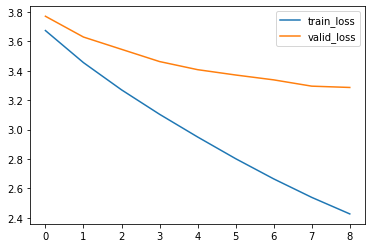

Epoch: 8 
 Train Loss 2.42589  Val loss 3.28613:
Train Perplexity 11.31229288103895  Val Perplexity 26.739182525938503:


KeyboardInterrupt: ignored

In [130]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

max_epochs = 10
CLIP = 1

# TODO
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

best_valid_loss = float('inf')
history_val = []
history_train = []

for epoch in range(max_epochs):
    
    
    train_loss = round(train(model, train_iterator, optimizer, criterion, CLIP), 5)
    valid_loss = round(evaluate(model, valid_iterator, criterion),5)
    history_val.append(valid_loss)
    history_train.append(train_loss)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
  
    clear_output(True)
    plt.plot(history_train, label = 'train_loss')
    plt.plot(history_val, label = 'valid_loss')
    plt.legend()
    plt.show()
    print('Epoch: {} \n Train Loss {}  Val loss {}:'.format(epoch, train_loss, valid_loss))
    print('Train Perplexity {}  Val Perplexity {}:'.format(np.exp(train_loss), np.exp(valid_loss)))


In [131]:
test_loss = evaluate(model, test_iterator, criterion)

print('| Test Loss: {} Test PPL:{}|'.format(test_loss, np.exp(test_loss)))

| Test Loss: 3.3177448362112045 Test PPL:27.598042221711367|


In [0]:
"""EOS_IDX = SRC.vocab.stoi['<eos>']

def translate(sentence):
    """
    function that uses .translate() method of the model to translate german sentence into english
    params:
        sentence: tokenized gernam sentence
    """
    sentence = sentence.lower()
    sent_vec = SRC.process([sentence]).to(device)
    translation_idx = model.translate(sent_vec)
    print(translation_idx)
    for t in translation_idx:
        if t[0] != EOS_IDX:
            print(TRG.vocab.itos[t[0]], end=' ')
        else:
            break"""

In [0]:
def translate(sentence):
    sent_vec = SRC.process([sentence]).to(device)
    input = torch.zeros((10, 1)).type(torch.LongTensor).to(device)
    input += SRC.vocab.stoi['<sos>']
    output = model(sent_vec, input, 0)
    vyvod = []
    for t in output:
        if t[0].max(0)[1] != SRC.vocab.stoi['<eos>']:
            vyvod.append(TRG.vocab.itos[t[0].max(0)[1]])
        else:
            break
    return vyvod

In [133]:
translate("ein klein apfel")

['<unk>',
 'college',
 'college',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>']

ИИИИ давайте также научимся считать самую популярную метрику для перевода -- BLEU (https://en.wikipedia.org/wiki/BLEU)

В общем-то, вам повезло -- ее писать руками скучно, да и nltk ее написало за вас:

In [0]:
a = [[SRC.vocab.itos[j] for j in next(iter(test_iterator)).src[:, i]] for i in range(64)]
b = [[TRG.vocab.itos[j] for j in next(iter(test_iterator)).trg[:, i]] for i in range(64)]

In [0]:
from nltk.translate.bleu_score import corpus_bleu
def compute_bleu(inp_lines, out_lines):
    """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
    translations = [translate(line) for line in inp_lines]
    return corpus_bleu(out_lines, translations) * 100

In [135]:
compute_bleu(a, b)

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


59.90401015065729

Если вы реализовали несколько методов аттеншена, опишите каждый из них и полученную метрику на нем в отчете.

<Место для вашего отчета>